In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm
import bnpm.plotting_helpers
import bnpm.path_helpers
import bnpm.timeSeries
import bnpm.ca2p_preprocessing
import bnpm.math_functions
import bnpm.h5_handling

In [4]:
paths_videos_exp = bnpm.path_helpers.find_paths('/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp', reMatch='exp_00001_')[:]
paths_videos_zstack = bnpm.path_helpers.find_paths('/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/zstack', reMatch='zstack_960')[:]

display(paths_videos_exp)
display(paths_videos_zstack)

['/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00001.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00002.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00003.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00004.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00005.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00006.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00007.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00008.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00009.tif',
 '/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/exp/exp_00001_00010.tif',
 '/media/rich/bigSSD/data_raw/

['/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/scanimage_data/zstack/zstack_960nm.tif']

In [5]:
frames_zstack = bnpm.ca2p_preprocessing.import_tiffs_SI(
    paths_videos_zstack[0],
    downsample_factors=[1,1,1], 
    clip_zero=True, 
    dtype=np.uint16, 
    verbose=True,
)

In [6]:
frames_metadata = bnpm.ca2p_preprocessing.get_ScanImage_tiff_metadata(paths_videos_zstack[0])

In [7]:
stack_out, positions_z, idx_slices = bnpm.ca2p_preprocessing.dense_stack_to_sparse_stack_SI(
    frames_zstack, 
    scanimage_metadata=frames_metadata,
    frames_to_discard_per_slice=30, 
    sparse_step_size_um=0.8,
    verbose=True,
)

Args found from scanimage_metadata:
  num_frames_per_slice = 60
  num_slices =           25
  num_volumes =          10
  step_size_um =         0.8

stack_in.shape =         (15000, 512, 1024)
stack_out.shape =        (25, 512, 1024)
positions_z =            -9.6, -8.8, -8.0, -7.2, -6.4, -5.6, -4.8, -4.0, -3.2, -2.4, -1.6, -0.8, 0.0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8, 5.6, 6.4, 7.2, 8.0, 8.8, 9.6, 
idx_slices =             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [10]:
outs = [bnpm.ca2p_preprocessing.find_zShifts(
    stack_out,
    positions_z=positions_z,
    path_to_tiff=path,
    frames=None,
    clip_zero=True,
    downsample_factors=[1,1,1],
    dtype=np.uint16,
    bandpass_spatialFs_bounds=(0.02, 0.3),
    order_butter=5,
    use_GPU=True,
    batch_size=50,
    resample_factor=100,
    sig=6.0,
    verbose=False,
) for path in tqdm(paths_videos_exp[:])]

positions_interp, zShift_interp, z_cc_interp = [[o[ii] for o in outs] for ii in range(3)]

positions_interp = np.concatenate(positions_interp).astype(np.float32)
z_cc_interp = np.concatenate(z_cc_interp, axis=0).astype(np.float32)
zShift_interp = zShift_interp[0].astype(np.float32)



  0%|                                                   | 0/108 [00:24<?, ?it/s]


  1%|▍                                          | 1/108 [00:06<11:02,  6.19s/it]

  2%|▊                                          | 2/108 [00:12<10:49,  6.13s/it]

  3%|█▏                                         | 3/108 [00:18<10:43,  6.13s/it]

  4%|█▌                                         | 4/108 [00:24<10:39,  6.15s/it]

  5%|█▉                                         | 5/108 [00:30<10:30,  6.12s/it]

  6%|██▍                                        | 6/108 [00:36<10:28,  6.16s/it]

  6%|██▊                                        | 7/108 [00:43<10:26,  6.20s/it]

  7%|███▏                                       | 8/108 [00:49<10:21,  6.21s/it]

  8%|███▌                                       | 9/108 [00:55<10:18,  6.25s/it]

  9%|███▉                                      | 10/108 [01:02<10:13,  6.26s/it]

 10%|████▎                                     | 11/108 [01:08<10:07,  6.26s/it]

 11%|████▋   

 86%|████████████████████████████████████▏     | 93/108 [14:18<02:36, 10.41s/it]

 87%|████████████████████████████████████▌     | 94/108 [14:28<02:24, 10.35s/it]

 88%|████████████████████████████████████▉     | 95/108 [14:39<02:15, 10.45s/it]

 89%|█████████████████████████████████████▎    | 96/108 [14:48<02:02, 10.24s/it]

 90%|█████████████████████████████████████▋    | 97/108 [14:58<01:51, 10.15s/it]

 91%|██████████████████████████████████████    | 98/108 [15:08<01:40, 10.02s/it]

 92%|██████████████████████████████████████▌   | 99/108 [15:18<01:30, 10.05s/it]

 93%|█████████████████████████████████████▉   | 100/108 [15:29<01:21, 10.18s/it]

 94%|██████████████████████████████████████▎  | 101/108 [15:38<01:10, 10.12s/it]

 94%|██████████████████████████████████████▋  | 102/108 [15:49<01:01, 10.19s/it]

 95%|███████████████████████████████████████  | 103/108 [15:59<00:50, 10.19s/it]

 96%|███████████████████████████████████████▍ | 104/108 [16:11<00:43, 10.84s/it]

 97%|███████████

<IPython.core.display.Javascript object>


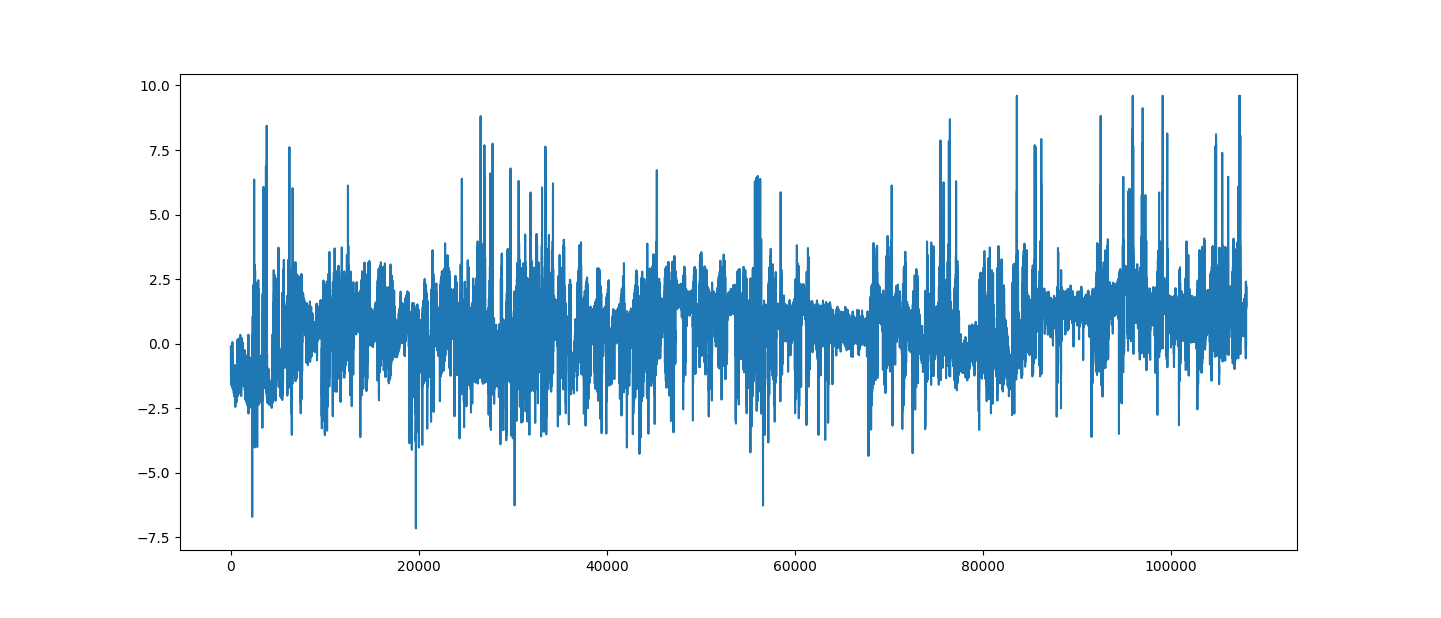

In [11]:
%matplotlib notebook
plt.figure()
plt.plot(positions_interp);

<IPython.core.display.Javascript object>


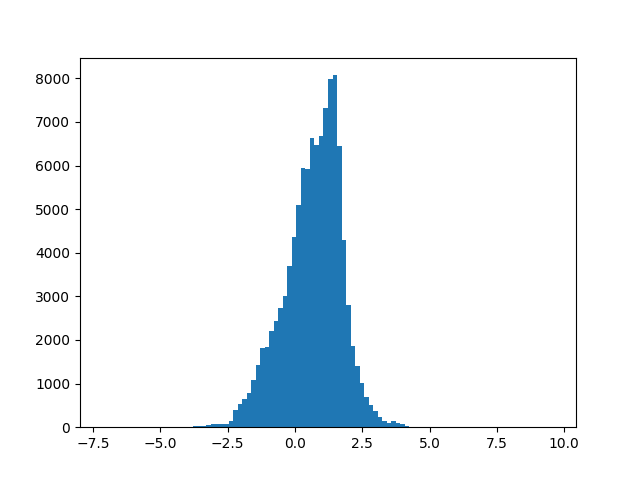

In [16]:
plt.figure()
plt.hist(positions_interp, 100);

In [14]:
results = {
    'zPositions': positions_interp,
    'zAxis': zShift_interp,
    'stack_sparse': stack_out,
}

bnpm.h5_handling.simple_save(
    dict_to_save=results,
    path='/media/rich/bigSSD/data_raw/BMI/mouse_g8test/20230314/analysis_data/z_positions.h5',
    verbose=True,
)

==== Successfully wrote h5 file. Displaying h5 hierarchy ====
1. zPositions:      shape=(108000,) ,   dtype=float32
2. zAxis:           shape=(2500,) ,     dtype=float32
3. stack_sparse:    shape=(25, 512, 1024) ,dtype=float64


- threshold triggered average
- correlation with factor magnitudes (especially avgVec)